In [1]:
import numpy as np
import pandas as pd
import os

repo_path = os.getcwd()
folder_path = os.path.join(repo_path, "input")

for dirname, _, filenames in os.walk(folder_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/Users/24emilyk/Desktop/2022-23/polygence/input/.DS_Store
/Users/24emilyk/Desktop/2022-23/polygence/input/scores.csv
/Users/24emilyk/Desktop/2022-23/polygence/input/condition/condition_23.csv
/Users/24emilyk/Desktop/2022-23/polygence/input/condition/condition_22.csv
/Users/24emilyk/Desktop/2022-23/polygence/input/condition/condition_20.csv
/Users/24emilyk/Desktop/2022-23/polygence/input/condition/condition_21.csv
/Users/24emilyk/Desktop/2022-23/polygence/input/condition/condition_19.csv
/Users/24emilyk/Desktop/2022-23/polygence/input/condition/condition_18.csv
/Users/24emilyk/Desktop/2022-23/polygence/input/condition/condition_7.csv
/Users/24emilyk/Desktop/2022-23/polygence/input/condition/condition_6.csv
/Users/24emilyk/Desktop/2022-23/polygence/input/condition/condition_4.csv
/Users/24emilyk/Desktop/2022-23/polygence/input/condition/condition_5.csv
/Users/24emilyk/Desktop/2022-23/polygence/input/condition/condition_1.csv
/Users/24emilyk/Desktop/2022-23/polygence/input/condition/condi

In [2]:
#load in MADRS1 and MADRS2 scores
scores_path = os.path.join(folder_path, "scores.csv")
scores = pd.read_csv(scores_path)
MADRS1 = np.array(scores["madrs1"])
MADRS2 = np.array(scores["madrs2"])
MADRS = np.vstack((MADRS1,MADRS2))

# discard NaN, keep the average of only condition subjects for convenience
import math
nanvals = np.where(np.isnan(MADRS))
MADRScondition = np.delete(MADRS, nanvals[1], 1)
MADRScondition = np.mean(MADRScondition, axis = 0)
MADRScontrol = (np.ones(32))*(-1)

print(MADRScondition)
print(MADRScontrol)
print(MADRScondition.shape)
print(MADRScontrol.shape)

[19.  17.5 24.5 18.  26.  16.5 24.5 18.  26.  24.5 24.  23.  15.5 23.5
 16.  15.  16.  16.5 23.5 26.  23.5 28.5 26. ]
[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
(23,)
(32,)


In [3]:
def convert_timestamps(timestamps): # reformatting time series data
    from datetime import datetime
    HH_MM = [0, 0]*len(timestamps)   
    for i in range(len(timestamps)):
        t = timestamps.iloc[i][0]
        d = datetime.strptime(t, '%Y-%m-%d %H:%M:%S')       
        h,m = d.hour, d.minute
        HH_MM[i] = h,m        
    return HH_MM

def read_subject(cohort,subj): # read subject data from the folder
    filename = f"{cohort}_{subj}.csv"
    file_path = os.path.join(folder_path, cohort, filename)

    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return None, None  # Return None if the file is missing
    
    try:
        file = pd.read_csv(file_path, header=0)
        timestamps = file.iloc[:, [0]]
        activity = file.iloc[:, [2]]
        
        HH_MM = convert_timestamps(timestamps)

        # Convert dataframe to array
        activity = np.array(activity).flatten()

        return HH_MM, activity
    except Exception as e:
        print(f"Error reading file {filename}: {e}")
        return None, None  # Handle errors gracefully

def rearrange_in_days(HH_MM, activity): # stacks days of recorded activity
    # Find indices where time is midnight (00:00)
    midnights = idx(HH_MM,(0,0))    
    # Extract each day's data
    for i in range(0,len(midnights)-1):
        day_i = activity[midnights[i]:(midnights[i+1]-1)]
        if i==0: rec = day_i
        elif len(day_i)==minutesinaday: rec = np.vstack((rec,day_i))
    return rec

def gather_data(cohort,subj): # bridge function: use rearrange_in_days and read_subject together
    HH_MM,activity = read_subject(cohort,subj)
    # Rearrange activity data by days
    days = rearrange_in_days(HH_MM, activity) 
    return days

def idx(l, target): # returns the position of every occurence of 'target'
    output = []
    for i in range(len(l)):
        if l[i]==target:
            output.append(i)
    return output

def get_subj_index(cohort,subj,I): # finding specific subjects' data in a structured array
    if cohort == "condition":
        subj = subj+32  
    i = np.where(I == subj)
    istart = i[0][0]
    iend = i[0][-1]
    return (istart, iend)

def visualize_data(x,y,style,col = 'black',T ='', l='',xl='', yl='',xlimit=None):
    import matplotlib.pyplot as plt
    if style =='plot':
        plt.plot(x,y,color = col, label = l)
    if style =='scatter':
        plt.scatter(x,y,color = col, label = l)  
    plt.xlabel(xl)
    plt.ylabel(yl)
    plt.title(T)
    if not(xlimit is None):
        plt.xlim((xlimit[0],xlimit[1]))
    return None  
    
def feature_extract(X):
    featurevec = []
    t = np.linspace(0,360-(360/1439),1439)
    # Extract features for each day's data
    for day in X:
        f1 = np.mean(day)  # Mean activity
        f2 = np.std(day)   # Standard deviation of activity
        f3 = np.max(day)   # Maximum activity
        f,f4,f5,f6= cosinor(t,day)  # Cosinor analysis features
        f8 = np.sum(day)**2  # Squared sum of activity
        featurevec.append([f1,f2,f3,f5,f6])
    
    X_feat = np.array(featurevec)
    return X_feat

In [4]:
# initializing X and Y arrays
Ncontr = 32 # number of control subjects
Ncond  = 23 # number of condition subjects
minutesinaday = 1439 # number of minutes from 00:00 to 23:59

# Initialize counter for subject IDs
counter = 1

# Process control subjects
for subj in range(1,Ncontr):
    cohort = "control"
    
    # Get activity data for current subject
    days = gather_data(cohort,subj)
    ndays = days.shape[0]
    
    # Create arrays of zeros for MADRS scores and subject IDs
    MADRSzeros = np.zeros(ndays,dtype = int)
    subj_id= np.ones(ndays,dtype = int) * counter
    counter += 1
    
    if subj == 1: # Initialize main arrays with first subject
        Y = MADRSzeros # MADRS scores array
        X = days       # Activity data array  
        ID= subj_id    # Subject ID array
        
    else:         # Add subsequent subjects to arrays
        X = np.vstack((X,days))        # Stack activity data vertically
        Y = np.hstack((Y,MADRSzeros))  # Concatenate MADRS scores horizontally
        ID= np.hstack((ID,subj_id))    # Concatenate subject IDs horizontally

# Process condition subjects    
for subj in range(1, Ncond):
    cohort = "condition"
    
    days = gather_data(cohort,subj)
    ndays = days.shape[0]
    
    # Create arrays of ones for MADRS scores and subject IDs
    MADRSones = np.ones(ndays,dtype = int)
    subj_id= np.ones(ndays,dtype = int) * counter
    counter += 1
    
    # Add condition subjects to existing arrays
    X = np.vstack((X,days))        # Stack activity data vertically
    Y = np.hstack((Y,MADRSones))   # Concatenate MADRS scores horizontally
    ID= np.hstack((ID,subj_id))    # Concatenate subject IDs horizontally
    
print(X)
print(Y)
print(ID)

/var/folders/tf/z2pkpmcx1yb36zdxnlpq9k7h0000gq/T/ipykernel_40985/2959065380.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t = timestamps.iloc[i][0]
/var/folders/tf/z2pkpmcx1yb36zdxnlpq9k7h0000gq/T/ipykernel_40985/2959065380.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t = timestamps.iloc[i][0]
/var/folders/tf/z2pkpmcx1yb36zdxnlpq9k7h0000gq/T/ipykernel_40985/2959065380.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  

[[   0    0    0 ...    0    0    0]
 [  73    0    0 ... 1002   57  111]
 [ 231   15    0 ...    0    0  620]
 ...
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0

there are approximately  213  suspiciously low-activity days


Text(0.5, 0.98, 'suspicious recordings')

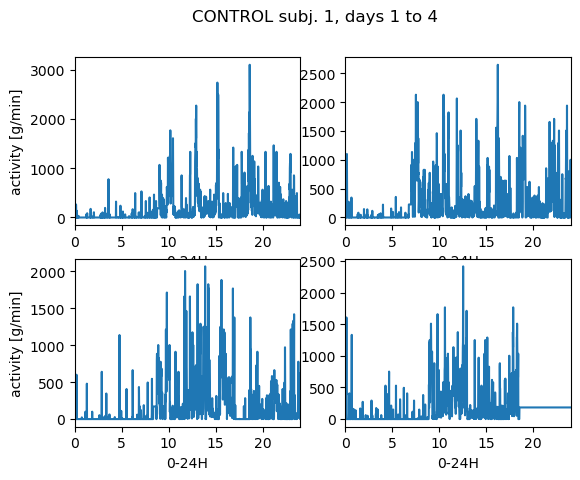

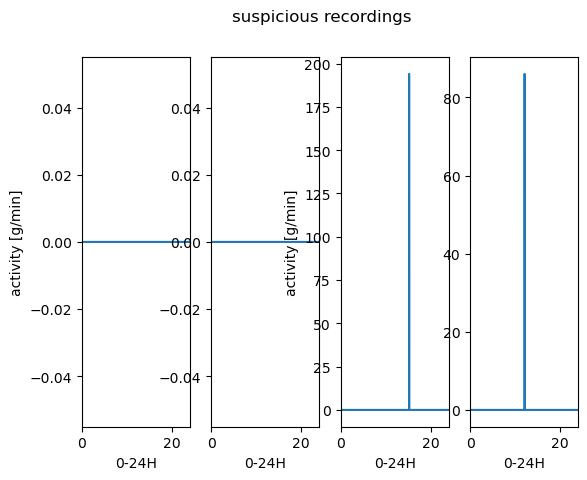

In [5]:
# Create time axis array from 0 to 24 hours with 0.0167 hour intervals
import matplotlib.pyplot as plt  
ax = np.arange(0, 24+0.0167, 0.0167)

# Create 2x2 subplot grid showing activity data for first 4 days
plt.figure(0)
plt.subplot(2,2,1)
plt.plot(ax, X[0])
plt.ylabel("activity [g/min]"), plt.xlabel("0-24H"),plt.xlim(0,24)
plt.subplot(2,2,2)
plt.plot(ax, X[1])
plt.xlabel("0-24H"),plt.xlim(0,24)
plt.subplot(2,2,3)
plt.plot(ax, X[2])
plt.ylabel("activity [g/min]"), plt.xlabel("0-24H"),plt.xlim(0,24)
plt.subplot(2,2,4)
plt.plot(ax, X[3])
plt.xlabel("0-24H"),plt.xlim(0,24)
plt.suptitle("CONTROL subj. 1, days 1 to 4")

# Identify days with suspiciously low activity (below threshold)
threshold = 25 
X_mean = np.mean(X,axis=1)  # Calculate mean activity for each day
sus = np.where(X_mean<threshold)  # Find indices where mean is below threshold
sus = sus[0]
print("there are approximately ",len(sus)," suspiciously low-activity days")

# Plot the suspicious days in a 1x4 subplot grid
plt.figure()
plt.subplot(1,4,1)
plt.plot(ax,X[sus[0]]),plt.ylabel("activity [g/min]"), plt.xlabel("0-24H"),plt.xlim(0,24)
plt.subplot(1,4,2)
plt.plot(ax,X[sus[1]]), plt.xlabel("0-24H"),plt.xlim(0,24)
plt.subplot(1,4,3)
plt.plot(ax,X[sus[2]]),plt.ylabel("activity [g/min]"), plt.xlabel("0-24H"),plt.xlim(0,24)
plt.subplot(1,4,4)
plt.plot(ax,X[sus[3]]), plt.xlabel("0-24H"),plt.xlim(0,24)
plt.suptitle("suspicious recordings")

original dataset size:  (974, 1439)
cleaned dataset size:  (761, 1439)


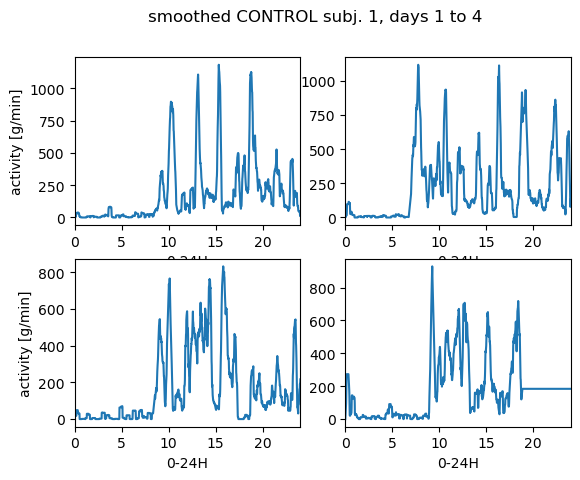

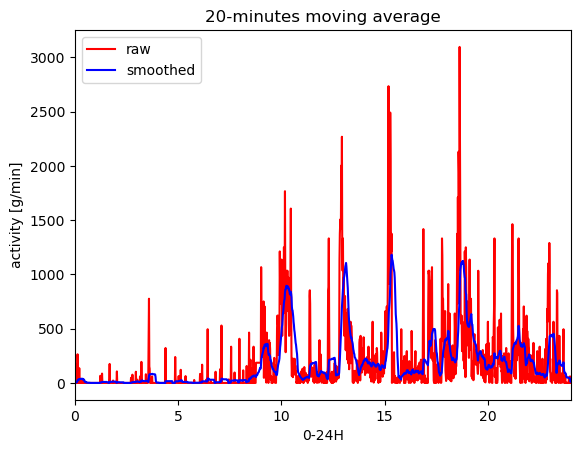

In [6]:
# Print original dataset dimensions
print("original dataset size: ",X.shape)

# Remove suspicious data points from X, Y and ID arrays
X = np.delete(X,sus,axis=0)
Y = np.delete(Y,sus,axis=0)
ID= np.delete(ID,sus,axis=0)

# Print dimensions after cleaning
print("cleaned dataset size: ",X.shape)

# Function to smooth time series data using moving average filter
def smooth(day,win):
    from scipy import signal
    import numpy as np
    
    L = win # moving average filter window length
    b = (np.ones(L))/L # Create filter coefficients (uniform weights)
    a = np.ones(1)     # Denominator coefficient for filter
    x = day            # Input signal
    y = signal.lfilter(b,a,x) # Apply filter to signal
    return y

# Apply 20-minute moving average filter to each day's data
window = 20
for i in range(0,X.shape[0]):
    day = X[i]
    smoothed_day = smooth(day,window)
    
    # Initialize or stack smoothed data
    if i==0: 
        X_smooth = smoothed_day
    else: 
        X_smooth = np.vstack((X_smooth,smoothed_day))

# Subplot figure showing smoothed activity data for first 4 days    
plt.figure()
plt.subplot(2,2,1)
plt.plot(ax, X_smooth[0])
plt.ylabel("activity [g/min]"), plt.xlabel("0-24H"),plt.xlim(0,24)
plt.subplot(2,2,2)
plt.plot(ax, X_smooth[1])
plt.xlabel("0-24H"),plt.xlim(0,24)
plt.subplot(2,2,3)
plt.plot(ax, X_smooth[2])
plt.ylabel("activity [g/min]"), plt.xlabel("0-24H"),plt.xlim(0,24)
plt.subplot(2,2,4)
plt.plot(ax, X_smooth[3])
plt.xlabel("0-24H"),plt.xlim(0,24)
plt.suptitle("smoothed CONTROL subj. 1, days 1 to 4")

# Comparison plot of raw vs smoothed data for first day
plt.figure()
plt.title("20-minutes moving average")
plt.plot(ax,X[0],color='r',label="raw"),plt.ylabel("activity [g/min]")
plt.plot(ax,X_smooth[0],color='b',label="smoothed"),plt.xlabel("0-24H"),plt.xlim(0,24)
plt.legend()
plt.show()

In [7]:
# Verifying data dimensions after cleaning
#print(X.shape)
#print(Y.shape)

In [8]:
# Linear regression

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_squared_error

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Standardizing features

# Polynomial features for non-linearity
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_scaled)  # expanding features

x_train, x_test, y_train, y_test = train_test_split(X_poly, Y, test_size=0.2, random_state=42)

# Ridge Regression
ridge = Ridge(alpha=1.0)  # Regularization strength
ridge.fit(x_train, y_train)

y_prediction = ridge.predict(x_test)

r2 = r2_score(y_test, y_prediction)
mse = mean_squared_error(y_test, y_prediction)
rmse = np.sqrt(mse)

print("Results for Linear Regression model")
print("r2 score is " + str(r2))
print("mean_sqrd_error is "+ str(mse))
print("root_mean_squared error is " + str(rmse))

Results for Linear Regression model
r2 score is -0.054910841689935985
mean_sqrd_error is 0.2566864092556655
root_mean_squared error is 0.5066422892491955


In [9]:
#XGBoost

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  

# Stratified train-test split
x_train, x_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42, stratify=Y)

# optimizing
XGB = XGBClassifier(
    n_estimators=200,       # More trees
    learning_rate=0.05,     # Slower learning rate 
    max_depth=5,            
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(XGB, X_scaled, Y, cv=cv, scoring='accuracy')
print(f"Cross-Validation Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

XGB.fit(x_train, y_train)

y_pred = XGB.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"XGBoost Test Accuracy: {accuracy:.4f}")

print("\nClassification Report:\n", classification_report(y_test, y_pred))

Cross-Validation Accuracy: 0.7411 ± 0.0270
XGBoost Test Accuracy: 0.7908

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.86      0.83        90
           1       0.77      0.70      0.73        63

    accuracy                           0.79       153
   macro avg       0.79      0.78      0.78       153
weighted avg       0.79      0.79      0.79       153



In [10]:
#Support Vector Machine (SVM)

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

x_train, x_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

# Hyperparameter tuning with grid search
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

svm_model = SVC(probability=True, random_state=42)
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(x_train, y_train)

best_svm = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

y_pred = best_svm.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"SVM Accuracy: {accuracy:.4f}")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
SVM Accuracy: 0.7190


In [11]:
# Random Forest Regressor

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

x_train, x_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

# optimizing hyperparameters
RF = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=3,
    random_state=42,
    n_jobs=-1
)

# 5-fold cross-validation
cv_scores = cross_val_score(RF, X_scaled, Y, cv=5, scoring='r2')

print(f"Cross-Validation R² Score: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

RF.fit(x_train, y_train)

y_pred = RF.predict(x_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Test R² Score: {r2:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")

Cross-Validation R² Score: -0.5047 ± 1.0094
Test R² Score: 0.2265
Mean Squared Error: 0.1882
Root Mean Squared Error: 0.4338


In [12]:
# Multi-Layer Perceptron (manual tuning)

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

x_train, x_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

MLP = MLPClassifier(
    hidden_layer_sizes=(64, 32, 16),  # deeper network
    activation='relu',
    solver='adam',                     # gradient descent
    alpha=0.0001,
    batch_size=64,
    learning_rate_init=0.005,          # Lower LR
    max_iter=2000,
    early_stopping=True,
    n_iter_no_change=20,
    verbose=False
)

MLP.fit(x_train, y_train)

y_pred = MLP.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"MLP Accuracy: {accuracy:.4f}")

MLP Accuracy: 0.7190


In [13]:
#Multi-Layer Perceptron (MLP) with grid-search optimization

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

x_train, x_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

# Defining MLP with optimized hyperparameters
MLP = MLPClassifier(max_iter=1000, early_stopping=True, random_state=42)

# Hyperparameter tuning with GridSearch
param_grid = {
    'hidden_layer_sizes': [(512, 256, 128), (256, 128, 64)], #different NN architectures
    'activation': ['relu', 'tanh'],
    'solver': ['lbfgs', 'adam'],
    'alpha': [0.0001, 0.001], #L2 regularizatino parameter
    'learning_rate_init': [0.001, 0.0005],
}

grid_search = GridSearchCV(MLP, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(x_train, y_train)

# Best model from GridSearch
best_mlp = grid_search.best_estimator_

y_pred = best_mlp.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Optimized MLP Accuracy: {accuracy:.4f}")
print(f"Best Parameters: {grid_search.best_params_}")

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   1.4s
[CV] END .................C=0.1, gamma=scale, kernel=sigmoid; total time=   1.2s
[CV] END .....................C=0.1, gamma=auto, kernel=poly; total time=   1.3s
[CV] END ....................C=1, gamma=scale, kernel=linear; total time=   1.2s
[CV] END ......................C=1, gamma=scale, kernel=poly; total time=   1.3s
[CV] END .....................C=1, gamma=auto, kernel=linear; total time=   1.2s
[CV] END .......................C=1, gamma=auto, kernel=poly; total time=   1.2s
[CV] END ......................C=10, gamma=scale, kernel=rbf; total time=   1.4s
[CV] END ..................C=10, gamma=scale, kernel=sigmoid; total time=   0.7s
[CV] END .......................C=10, gamma=auto, kernel=rbf; total time=   1.4s
[CV] END ...................C=10, gamma=auto, kernel=sigmoid; total time=   0.5s
[CV] END activation=relu, alpha=0.0001, hidden_

/Users/24emilyk/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   1.4s
[CV] END .................C=0.1, gamma=scale, kernel=sigmoid; total time=   1.1s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   1.2s
[CV] END ..................C=0.1, gamma=auto, kernel=sigmoid; total time=   1.0s
[CV] END ....................C=1, gamma=scale, kernel=linear; total time=   1.3s
[CV] END ...................C=1, gamma=scale, kernel=sigmoid; total time=   1.0s
[CV] END ........................C=1, gamma=auto, kernel=rbf; total time=   1.3s
[CV] END ...................C=10, gamma=scale, kernel=linear; total time=   1.0s
[CV] END .....................C=10, gamma=scale, kernel=poly; total time=   1.2s
[CV] END ....................C=10, gamma=auto, kernel=linear; total time=   1.1s
[CV] END ......................C=10, gamma=auto, kernel=poly; total time=   1.1s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(512, 256, 128), learning_rate_init=0.001, solver=